# Ribosome Profile Simulator

This script is used to create simulated ribosome profiles from scratch. The simulation works by drawing a set of elongation rates from a gamma distribution and then plugging those rates into the equations from the inhomogenous l-TASEP model in order to create estimations of ribosome density across the transcript. These distributions of ribosome density are then randomly sampled from in order to create the equivalent of 

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import keegan_analysis_tools as kat
import TASEP_tools as tt
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm

In [3]:
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'

## define functions

In [4]:
def big_dif(diff_dist, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
            my_vec_mutant = data_mutant[gi]
            my_vec_control = data_control[gi]
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + str(gi), fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + str(gi), fontsize = fontsize)
    fig.tight_layout()
            
    return ax

In [5]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [6]:
def det_p_values(ks_table, sections):
    p_values = []
    all_ks = ks_table
    ks_MC = ks_table[ks_table["phase_mutant"] == "MC"]
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(ks_MC.ks_stat[(ks_MC.ks_stat > sec) & (ks_MC.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(ks_MC.ks_stat[ks_MC.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

Just showing that the KS statistic works? 

Pick randomly and then decrease by a specific factor rather than a random factor. different levels, start with decreasing. 

Experiment with doing different read densities. 

Ok, basically do the proportion table thing for several different read densities to show that the KS-statistic can pick up on these differences no matter what. Do I want to set it up so that it creates a list of densities as well?

## Draw random samples from your particle densities

In [33]:
# Create a large number of simulations
data_control = []
j_control = []
phase_control = []
min_control = []
data_mutant = []
j_mutant = []
phase_mutant = []
min_mutant = []
for i in range(2000):
    length = numpy.random.randint(200,2500)
    #alpha = numpy.random.uniform(0.004,0.02)
    alpha = 0.01
    x = tt.simulate_profile(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, read_density = 0.5, pause_density = 0.01, pause_str = 0.16, 
                         a_frac = 1, elon_frac = 1, return_min_lam = True)
    data_control.append(x[0])
    j_control.append(x[1])
    phase_control.append(x[2])
    min_control.append(x[3])
    data_mutant.append(x[4])
    j_mutant.append(x[5])
    phase_mutant.append(x[6])
    min_mutant.append(x[7])

## Calculate Smoothed Vector Arrays

In [34]:
# Define the maximum number of processors that can be used when creating the smoothed vector arrays
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control = list(
         tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                      data_control),
            total=len(data_control)
        )
    )    

100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.40it/s]


In [35]:
# get smoothed vector arrays for all of the mutant data.
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
            total=len(data_mutant)
        )
    )    

100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.06it/s]


## Determine KS statistic for all transcripts

In [36]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
ks_list = []
len_list = []
id_list = []
x = -1
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    x = x+1
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]
    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))
    id_list.append(x)
            
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, j_control, j_mutant, phase_control, phase_mutant, min_control, min_mutant, len_list, id_list)))
df_b.columns = ["ks_stat","J_control", "J_mutant","phase_control", "phase_mutant","min_control", "min_mutant", "gene_length", "id"]
#df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
# Clear out unneeded lists
ks_list.clear()
len_list.clear()

In [37]:
df_sorted = df_b.sort_values(by = "ks_stat")

In [38]:
categories = []
for i in df_sorted.phase_mutant:
    if i == "MC":
        categories.append(0)
    elif i == "LD":
        categories.append(1)
    elif i == "HD":
        categories.append(2)
colormap = np.array(['purple','g','b'])

Text(0.5, 1.0, 'KS statistic of all simulated genes')

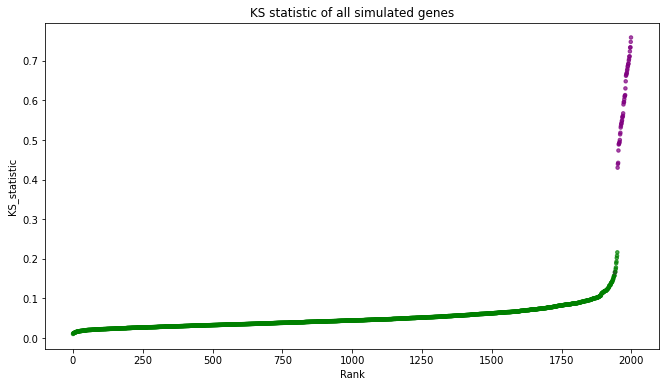

In [39]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), df_sorted["ks_stat"], s=12, alpha = 0.7, c= colormap[categories]) #ok, this works but I need to sort it first, 
#I can probably just sort the dataframe itself to do this. 
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all simulated genes")

In [40]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [41]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.15)&(df_b['ks_stat']<0.2)].groupby('id')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [42]:
len(diff_dist)

12

In [43]:
diff_dist.index

Int64Index([156, 228, 235, 278, 302, 403, 439, 752, 883, 970, 1042, 1080], dtype='int64', name='id')

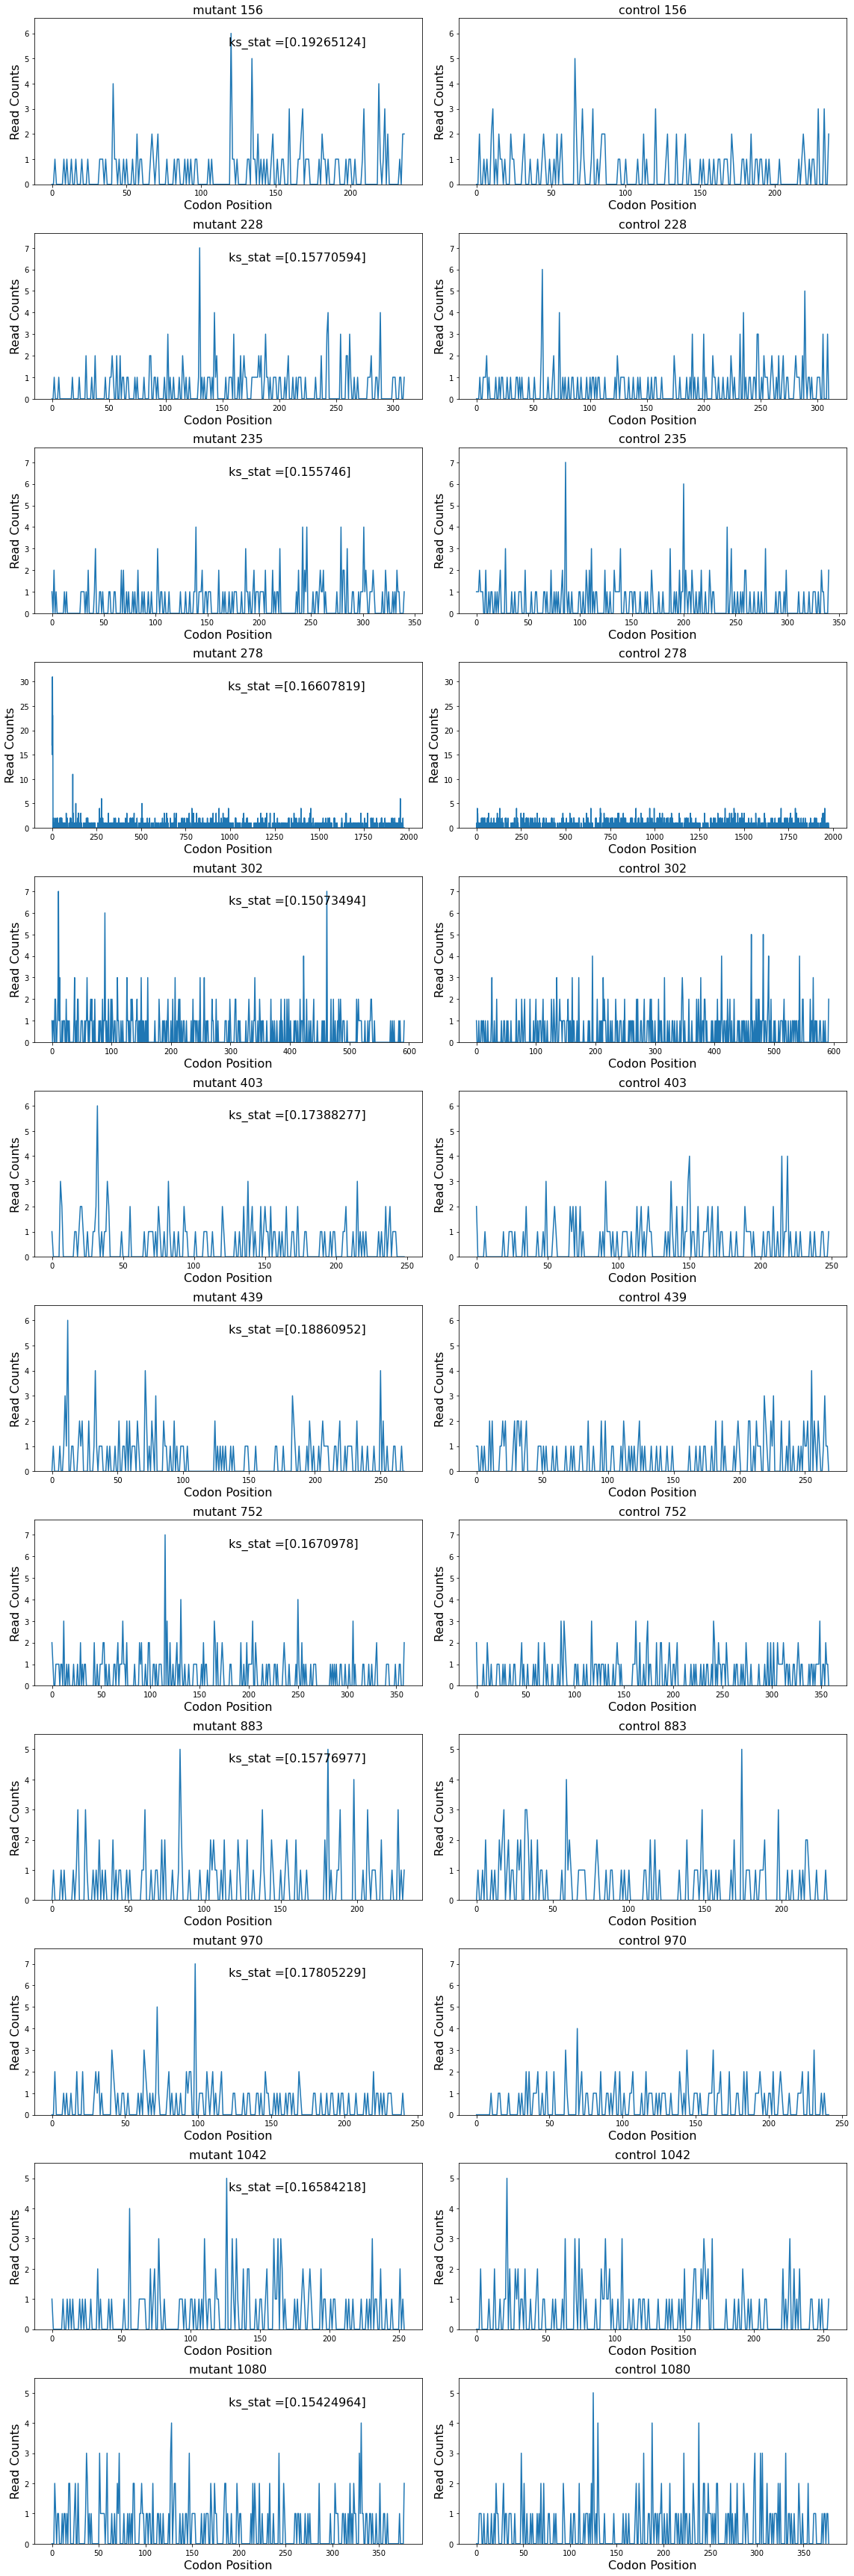

In [44]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = big_dif(diff_dist, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 16)

In [45]:
ratios, sections = tt.determine_sim_enrichment(df_b, 2, 0.2)

In [46]:
ratios

[0.0, 0.012345679012345678, 0.9423076923076923]

In [47]:
det_p_values(df_b, sections)

[0.3023596771895063, 4.725387821030719e-177]

Text(0, 0.5, 'KS Statistic')

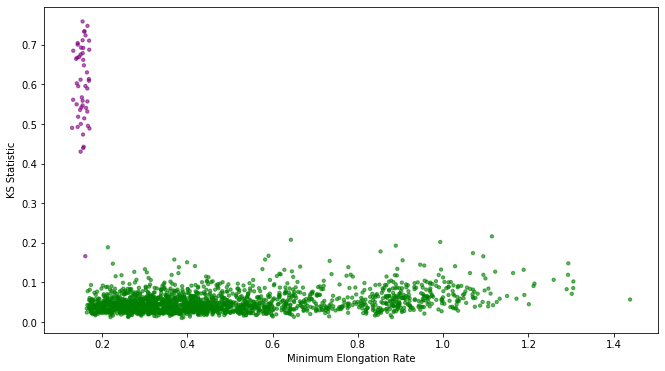

In [48]:
figure(figsize = (11,6))
plt.scatter(df_sorted.min_mutant, df_sorted.ks_stat,c= colormap[categories], s=11, alpha = 0.6)
plt.xlabel("Minimum Elongation Rate")
plt.ylabel("KS Statistic")

## Experimenting with making a phase diagram showing all points. 

In [49]:
# A list of all the outputs. (reads_c, J_c, phase_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c, term_l_c, reads_m, J_m, phase_m, a_m, B_m, 
#           crit_a_m, crit_B_m, min_l_m, ini_l_m, term_l_m)

In [50]:
data_control = []
data_mutant = []
J_control = []
J_mutant = []
phase_control = []
phase_mutant = []
alphas = []
mu_alphas = []
betas = []
mu_betas = []
crit_alphas = []
crit_betas = []
crit_mu_alphas = []
crit_mu_betas = []
min_lambs = []
mu_min_lambs = []
ini_lambs = []
mu_ini_lambs = []
term_lambs = []
mu_term_lambs = []
for i in range(25):
    length = numpy.random.randint(200,2500)
    alpha = numpy.random.uniform(0.004,0.02)
    x = tt.get_all_intermediates(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, read_density = 0.5, pause_N = 7, pause_str = 0.1, 
                         a_frac = 1, elon_frac = 1)
    data_control.append(x[0])
    J_control.append(x[1])
    phase_control.append(x[2])
    alphas.append(x[3])
    betas.append(x[4])
    crit_alphas.append(x[5])
    crit_betas.append(x[6])
    min_lambs.append(x[7])
    ini_lambs.append(x[8])
    term_lambs.append(x[9])
    data_mutant.append(x[10])
    J_mutant.append(x[11])
    phase_mutant.append(x[12])
    mu_alphas.append(x[13])
    mu_betas.append(x[14])
    crit_mu_alphas.append(x[15])
    crit_mu_betas.append(x[16])
    mu_min_lambs.append(x[17])
    mu_ini_lambs.append(x[18])
    mu_term_lambs.append(x[19])

In [51]:
np.where((np.array(alphas)/np.array(crit_alphas) == np.amax((np.array(alphas)/np.array(crit_alphas)))))

(array([7]),)

Set an arbitrary termination rate (say that termination rate does not have an effect on this process). 

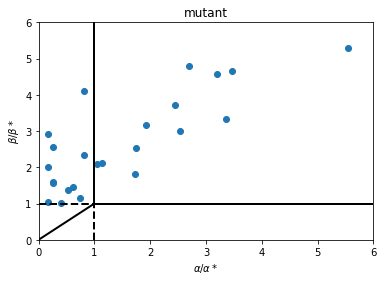

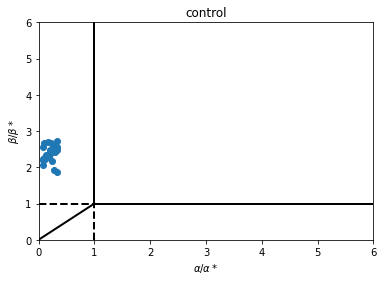

In [52]:
plt.scatter((np.array(mu_alphas)/np.array(crit_mu_alphas)), (np.array(mu_betas)/np.array(crit_mu_betas))*0.015)
plt.ylim([0,6])
plt.xlim([0,6])
plt.xlabel(r'$\alpha / \alpha*$')
plt.ylabel(r'$\beta / \beta*$')
plt.title("mutant")
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)
plt.show()
plt.scatter((np.array(alphas)/np.array(crit_alphas)), (np.array(betas)/np.array(crit_betas))*0.07)
plt.ylim([0,6])
plt.xlim([0,6])
plt.xlabel(r'$\alpha / \alpha*$')
plt.ylabel(r'$\beta / \beta*$')
plt.title("control")
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [53]:
from sympy import symbols, solve, sqrt

In [54]:
# create a function that can determine the 
def get_critical(alpha, l1, I = 10):
    lmin = symbols('lmin', positive = True, real = True)
    expr = ((l1 - (I-1) * (lmin/((1+sqrt(I))**2))) / 2)*(1 - sqrt(1 - (4*l1*(lmin/((1+sqrt(I))**2)))/((l1 - (I - 1)*(lmin/((1+sqrt(I))**2)))**2))) - alpha
    sol = solve(expr)
    return sol

In [55]:
ini_lambs[14]

11.747117938037327

In [56]:
x = get_critical(alphas[14],ini_lambs[14])

In [57]:
ini_lambs[14]/x[0]

153.701042466015